In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt   
import math
from tabulate import tabulate
from matplotlib.backends.backend_pdf import PdfPages
import os 
import site
import sys

import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
# suppress SettingWithCopy warning
pd.options.mode.chained_assignment = None     
warnings.filterwarnings("ignore", category=UserWarning)
# df.append will be deprecated, use pd.concat
warnings.filterwarnings("ignore", category=FutureWarning) 

### Functions

In [ ]:
def normalize_params(array_name):
    """Function normalizing model parameters using the parameter limits Pmin_array
        and Pmax_array. The normalized array is used for calculating distances during
        the model selection process
        
        input: ndarray
        array_name: the array to be normalized
        returns: normalized array
    """
    normed_array = (array_name - Pmin_array)/(Pmax_array - Pmin_array)
    return normed_array

def C_ensemblecalc(t, x):
    """Function for calculating concentrations of ensemble parameter values
    at every timestep.
        input: 
        t should be t_obs or t_pred
        x should be x_obs or x_pred
        initial_c is the initial concentration
        pulse time is the point source release 
        x_obs is the observation distance from source 
        R, D, Lambda, v are the model parameters
        returns: ndarray of ensemble concentrations     
    """
    C_ensemble = np.zeros((np.shape(t)[0], np.shape(R)[0]))
    for i in range(len(R)):
        C_ensemble[:,i] = ((initial_c*pulse_time*x*R[i]**.5)/
        (2*(math.pi*D[i]*(t**3))**.5))*\
        np.exp(-((R[i]*x-v[i]*t)**2)/(4*R[i]*D[i]*t))*\
        np.exp(-Lambda[i]*t)

        C_ensemble[np.where(C_ensemble<0)]=0
        C_ensemble[np.where(np.isinf(C_ensemble)==1)]=0
        C_ensemble[np.where(np.isnan(C_ensemble)==1)]=0
    return C_ensemble


def C_initial_MOC_calc(t, x):
    """Function for calculating concentrations of ensemble parameter values
    at every timestep.
        input: 
        t should be t_obs or t_pred
        x should be x_obs or x_pred
        initial_c is the initial concentration
        pulse time is the point source release 
        x_obs is the observation distance from source
        R, D, Lambda, v are the model parameters
        returns: ndarray of ensemble concentrations     
    """
    C_initial_MOC_ensemble = np.zeros((np.shape(t)[0], np.shape(R)[0]))
    for i in range(len(R)):
        C_initial_MOC_ensemble[:,i] = ((initial_c*pulse_time*x*R[i]**.5)/
        (2*(math.pi*D[i]*(t**3))**.5))*\
        np.exp(-((R[i]*x-v[i]*t)**2)/(4*R[i]*D[i]*t))*\
        np.exp(-Lambda[i]*t)

        C_initial_MOC_ensemble[np.where(C_initial_MOC_ensemble<0)]=0
        C_initial_MOC_ensemble[np.where(np.isinf(C_initial_MOC_ensemble)==1)]=0
        C_initial_MOC_ensemble[np.where(np.isnan(C_initial_MOC_ensemble)==1)]=0
    return C_initial_MOC_ensemble

def C_truecalc(t,x):
    """Function for calculating concentrations with measured parameters at
        each timestep
        input: t_obs, x_obs or t_pred, x_pred
        x is the observation distance from source
        t is the number of timesteps 
        initial_c is the initial concentration 
        pulse time is the point source release 
        x_obs is the observation distance from source
        Rtrue, Dtrue, vtrue, Lambda_true are the parameters of the truth model
        returns: a true concentration value at every timestep
    """    
    C_true=np.zeros((np.shape(t)[0]))
    C_true[:]=((initial_c*pulse_time*x*Rtrue**.5)/
     (2*(math.pi*Dtrue*(t**3))**.5))*np.exp(-((Rtrue*x-vtrue*t)**2)/
      (4*Rtrue*Dtrue*t))*np.exp(-Lambdatrue*t)                          
    C_true[np.where(C_true<0)]=0
    C_true[np.where(np.isinf(C_true)==1)]=0
    C_true[np.where(np.isnan(C_true)==1)]=0
    err_val=np.random.normal(loc=0,scale=.02,size=(C_true.size))
    C_true=C_true+err_val
    return C_true   

def C_selectedcalc(t,x):
    """Function calculating concentration at each timestep for the metropolis
    models selected to consider for replacement in ensemble.
    input: t_obs, x_obs or t_pred, x_pred
    """
    C_selected = np.zeros((np.shape(t)[0], np.shape(R_selected)[0]))
    for i in range(len(R_selected)):
        C_selected[:,i] = ((initial_c*pulse_time*x*R_selected[i]**.5)/
        (2*(math.pi*D_selected[i]*(t**3))**.5))*\
        np.exp(-((R_selected[i]*x-v_selected[i]*t)**2)/(4*R_selected[i]*D_selected[i]*t))*\
        np.exp(-Lambda_selected[i]*t)
        C_selected[np.where(np.isnan(C_selected)==1)]=0
    return C_selected

def C_unknowncalc(t,x):
    """Function for calculating concentrations with measured parameters at
        each timestep
        input: t_obs, x_obs or t_pred, x_pred
        x is the observation distance from source input by user at top of code
        t is the number of timesteps input by user at top of code
        initial_c is the initial concentration input by user at top 
    """
    C_unknown=np.zeros((np.shape(t)[0], np.shape(R_unknown_MOC)[0]))
    for i in range(len(R_unknown_MOC)):
      C_unknown[:,i]=((initial_c*pulse_time*x*R_unknown_MOC[i]**.5)/
       (2*(math.pi*D_unknown_MOC[i]*(t**3))**.5))*np.exp(-((R_unknown_MOC[i]*x-v_unknown_MOC[i]*t)**2)/
        (4*R_unknown_MOC[i]*D_unknown_MOC[i]*t))*np.exp(-Lambda_unknown_MOC[i]*t)                          
      C_unknown[np.where(C_unknown<0)]=0
      C_unknown[np.where(np.isnan(C_unknown)==1)]=0
    return C_unknown 

def plot_Censemble():
    """Function for plotting ensemble concentrations against measured
        concentrations at each timestep, for every iteration of the ensemble.
        input: none
        variables:
        ensemble size is input by user at top of code
        t_obs is the number of timesteps input by user at top of code
        C_ensemble is calculated by previous function
        C_true is calculated by previous function
        threshold is set by user at top of code
        returns: a plot for each iteration of the model ensemble
    """
    for i in np.arange(ensemble_size):
        labelstr='model ' + str(i+1)
        plt.plot(t_obs, C_ensemble[:,i],label=labelstr)
    plt.plot(t_obs, C_true,'p', markersize = 3, label='Data w/error', color = 'black', lw = 2)
    plt.xlabel('Time (days)')
    plt.ylabel('Concentration (mg/L)')
    plt.title('Ensemble') 
    plt.legend()
    plt.show()
    return plt.plot()

def plot_CMOC_pred():
    """Function for plotting ensemble concentrations against measured
        concentrations at each timestep, for every iteration of the ensemble.

        input: none
        ensemble size is input by user at top of code
        t_obs is the number of timesteps input by user at top of code
        C_MOC_ensemble is calculated by previous function
        C_true is calculated by previous function
        returns: a plot for each iteration of the MOC ensemble
    """
    for i in np.arange(ensemble_size):
        labelstr='model ' + str(i+1)
        plt.plot(t_pred, C_MOC_ensemble_pred[:,i],label=labelstr)
    #plt.plot(t_obs,C_true,'p',markersize = 3,label='Data w/error',color ='black',lw = 2)
    plt.xlabel('Time (days)')
    plt.ylabel('Concentration (mg/L)')
    plt.title('MOC Ensemble Prediction') 
    plt.legend()
    plt.show()
    return plt.plot()

def plot_Cpred():
    """Function for plotting ensemble concentrations against measured
        concentrations at each timestep, for every iteration of the ensemble.
        input: none
        x: array, t_obs - number of timesteps, input by user at top of code
        y1: array, C_ensemble, calculated by previous function
        y2: array, C_true_pred, calculated by previous function
        returns: a plot for each iteration of the model ensemble
    """
    for i in np.arange(ensemble_size):
        labelstr='model ' + str(i+1)
        plt.plot(t_pred, C_ensemble_pred[:,i],label=labelstr)
        plt.xlabel('Time (days)')
    plt.ylabel('Concentration (mg/L)')
    plt.title('Ensemble Prediction') 
    plt.legend()
    plt.show()
    return plt.plot()

def distance_good(array_normed1, array_normed2, df_update):
    """Function to calculate distance between "good" ensemble model and each
        metropolis model, to select the closest metropolis model.
        input: ndarray
        array_normed1: normalized metropolis models
        array_normed2: normalized "good" ensemble model
        returns: a dataframe with the closet metropolis model and updates
        the input dataframe.dist column
    """
    this_distance = np.sqrt(np.sum(((array_normed1 - array_normed2)**2), axis = 1))
    df_update.dist = this_distance
    df_update = df_update.loc[df_update.groupby('dist').dist.idxmin()]\
                    .reset_index(drop=True)
    df_update.good_model[0] = 1                                                  
    metrop_close = df_update[df_update.good_model == 1]
    return metrop_close

def distance_far(array_extend, array_rotflip):                                    
    """Function to calculate distances between every previously sampled
        model and each metropolis model, to select the metropolis model that
        is farthest from all sampled. 

        input: ndarray, dataframe
        array_extend: normalized extended array of previously sampled
        array_rotflip: normalized metropolis array, rotated and flipped for
                        broadcasting
        metrop_close: dataframe containing metropolis model closest to "good"
                        ensemble model
        metrop: dataframe used to identify the xID of metropolis models

        returns: a dataframe containing the metropolis model closest to "good"
                ensemble model, and metropolis farthest from all sampled
    """
    distance_far = np.sqrt(np.sum(((array_extend - array_rotflip)**2), axis = 1))
    distance = pd.DataFrame(np.rot90(distance_far))                              
    distance.insert(0, 'xID', metrop.xID.to_list())
    distance.set_index(keys = 'xID', drop=True, append=False, inplace=True,
        verify_integrity=False)
    mins = distance[distance > 0].min(axis=1)
    max_min = mins.idxmax()
    metrop_far = metrop[metrop.xID == max_min]                                    
    two_metrop = [metrop_close, metrop_far]
    metrop_chosen = pd.concat(two_metrop)
    return metrop_chosen


### Variables

In [ ]:
# Primary variable: the number of iterations to run the mixed ensemble
test = 5                           

# secondary variables that may be adjusted
ensemble_size = 20  
num_replace_different = 4   # number of ensemble models replaced in each round
num_replace_good = 3        # number of metropolis close to the best ensemble model
metropolis_rounds = 10      # number of rounds to try metropolis replacement     
Pnum = 5000                 # size of parameter space 

trials = Pnum/ensemble_size - metropolis_rounds  # number of iterations to sample metropolis
the_seed = 0

initial_c = 1                      # source concentration                                                      
x_obs = 200                        # distance from source to sentry well
x_pred = 1000                      # distance from source to point of compliance
pulse_time = 127                   # duration of point source release
t_start = 0            
t_end = 200                        # days of observed concentration
t_end_pred = 1000                  # days of calculated predictions
dt = 10

meas_error_percent = 0             # add random relative error, zero mean                                                                    

U_th = .29                         # utility threshold for models of concern
C_0 = .38                          # concentration level where UCmax = 0
C_1 = .11                          # concentration level where UCmax = 1

MOC_size = 10                        # Variables for Round 2: MOC_ensemble size
len_R1R2 = ensemble_size + MOC_size                                    

num_close = 1                        # number of close metropolis models
num_far = 1                          # number of far metropolis models
new_rounds = 10                      # number of metropolis to sample 
MOCtrials = 10

t_obs = np.arange(t_start, t_end,dt)        # number of timesteps (days)
length = len(t_obs)
middle_index = length//2

t_pred = np.arange(t_start, t_end_pred,dt)

Params1 = ('v', 'D', 'Lambda', 'R','xsampled')                              
Plims=pd.DataFrame([[1,3],[10,100],[0,.005],[1,2],[0,0]])     # parameter limits
Plims.index = Params1
Plims.columns = ('minval','maxval')
Params = ('v', 'D', 'Lambda', 'R','xsampled','xID')
Plims_array = Plims.to_numpy()                                                    
Pmin_array = Plims_array[0:4,0]
Pmax_array = Plims_array[0:4,1]

failed_seed = []                                                                  
hold_R1R2_cumulative_util=np.zeros((test,2*ensemble_size))                        
hold_R1R2_cumulative_L_c=np.zeros((test,2*ensemble_size))                        
hold_R1R2_ensemble_util=np.zeros((test,2*ensemble_size))                          
hold_R1R2_ensemble_L_c=np.zeros((test,2*ensemble_size))                          
hold_truth_model_MOC=np.zeros((test))                                            
hold_C_ens_max = np.zeros((test,2*ensemble_size))
hold_C_vals = np.zeros((len(t_obs), ensemble_size))

#misfit
hold_R1R2_ensemble_misfit=np.zeros((test,2*ensemble_size))
hold_ens_util = np.zeros((test,2*ensemble_size))
hold_ens_misfit = np.zeros((test,2*ensemble_size))

days_0 = 305                                                                      
days_1 = 95 
w_days1 = 1
w_Cmax1 = 1

## Begin loop


count:  0


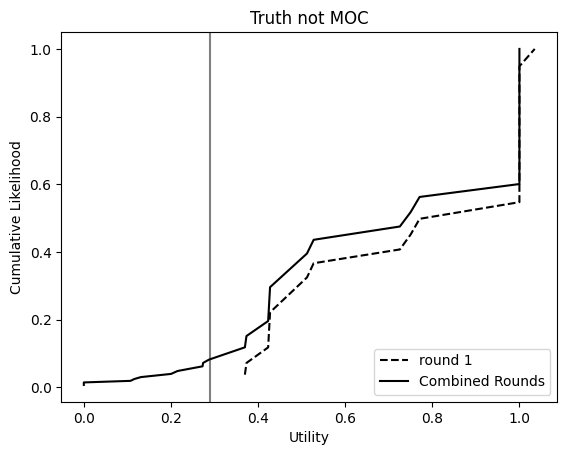


count:  1


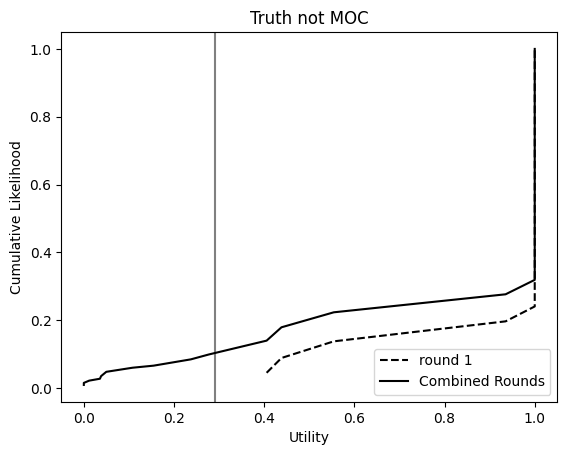


count:  2


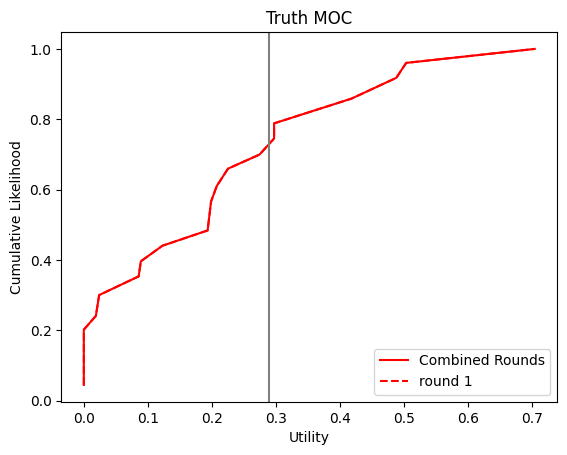


count:  3


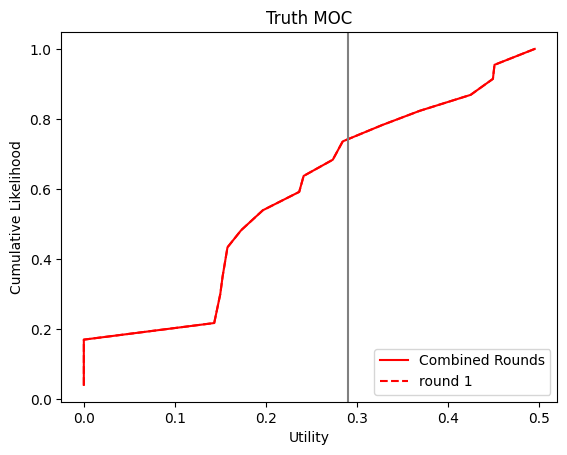


count:  4


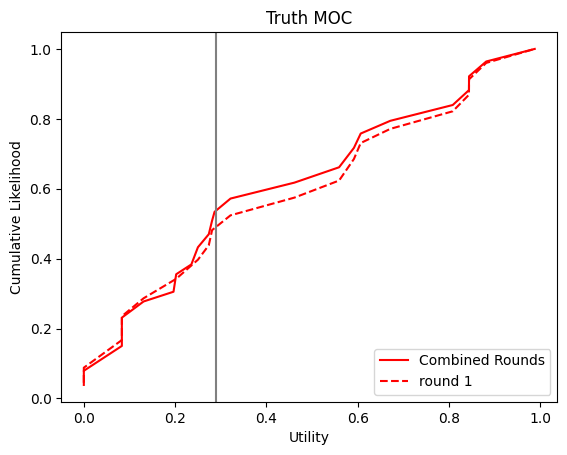

TN FN
FP TP

Round 1
2 3
0 0

Rounds 1&2
2 0
0 3


In [ ]:
truthseed = 1
for x in range(int(test)):
  print()
  print('count: ', x)
  np.random.seed(the_seed + x)                                                    
  Pspace = pd.DataFrame(np.random.rand(Pnum,Plims.shape[0]+1),columns=Params)
  Pspace = Pspace * (Plims.maxval-Plims.minval) + Plims.minval                    
  Pspace.xsampled=0                                                               
  Pspace.xID=np.arange(Pnum)                                                      
  Pspace['good_model'] = 0                                                        
  Pspace['RMSE'] = 0

  Pspace['ens'] = 0

  Pspace['dist'] = 0                                                                                                                   
  Pspace['days_over'] = 0                                                         
  Pspace['Udays'] = 0                                                             
  Pspace['Cmax'] = -1                                                              
  Pspace['UCmax'] = 99                                                           
  Pspace['Utotal'] = 99
  #Pspace['days1'] = 0
  Pspace = Pspace[['xID', 'RMSE','ens', 'D', 'Lambda', 'R', 'v', 'xsampled',
      'good_model','dist', 'days_over', 'Cmax', 'Udays', 'UCmax','Utotal']]                     
  util = ['Udays', 'UCmax']
  num_util = len(util)

  truth_model = Pspace[Pspace.xID == Pnum - 3]                                   
  Pspace.drop(Pspace.index[-3], inplace=True)                                     
  Rtrue = int(truth_model.R)                                                      
  Dtrue = int(truth_model.D)
  vtrue = int(truth_model.v)
  Lambdatrue = int(truth_model.Lambda) 
  C_true = C_truecalc(t_obs, x_obs)                                               
  C_true_pred = C_truecalc(t_pred, x_pred)                                            
  C_error = (np.random.rand(t_obs.shape[0])-0.5)*meas_error_percent/100
  C_true = C_true + C_error
  
  truth_model.Cmax = C_true_pred.max()                                            
  truth_model.UCmax = 1-((truth_model.Cmax - C_1) / (C_0 - C_1))                  
  truth_model.UCmax[truth_model.Cmax > C_0] = 0                                   
  truth_model.UCmax[truth_model.Cmax < C_1] = 1                                   
  truth_model.days_over = (np.count_nonzero(C_true_pred >= C_1, axis = 0)) * dt   
  truth_model.Udays = 1 - ((truth_model.days_over - days_1) / (days_0 - days_1))  
  truth_model.Udays[truth_model.days_over > days_0] = 0                           
  truth_model.Udays[truth_model.days_over < days_1] = 1                           
  truth_model.Utotal = (w_days1*truth_model.Udays)/num_util+(w_Cmax1*truth_model.UCmax)/num_util
  #truth_model.Utotal = 1-((truth_model.Cmax - C_1)/(C_0-C_1))  #ignore days_over

  truth_model.insert(1, 'U_th', U_th)                                             
  truth_model.insert(2, 'MOC', 0)                                                 
  truth_model.MOC[truth_model.Utotal < U_th] = 1                                   
  truth_model.drop(['xsampled', 'RMSE', 'xID', 'good_model', 'dist'], axis=1, inplace=True)                             

  ensemble = Pspace[Pspace.xsampled == 0][:ensemble_size]                         
  # mark the initial ensemble models as run
  ensemble.xsampled = 2                                                                                                                           
  Pspace.loc[Pspace.xID.isin(ensemble.xID), ['xsampled']] =\
          ensemble[['xsampled']].values                                           
  D = ensemble.D.to_numpy()                                                       
  Lambda = ensemble.Lambda.to_numpy()
  R = ensemble.R.to_numpy()
  v = ensemble.v.to_numpy()
  C_ensemble = C_ensemblecalc(t_obs, x_obs)                                         
  C_ensemble_pred = C_ensemblecalc(t_pred, x_pred)
  # Rotate from (20,10) to (10,20) and flip so that E1 first col, t1 first row                                
  C_ensemble_rot_flip = np.flipud(np.rot90(C_ensemble, k=1))                      
  rmse_ensemble = np.sqrt(np.mean(((C_ensemble_rot_flip - C_true)**2), axis = 1))         
  ensemble.RMSE = rmse_ensemble

  ensemble.Cmax = C_ensemble_pred.max(axis = 0)                                     
  ensemble.UCmax = 1 - ((ensemble.Cmax - C_1) / (C_0 - C_1))                      
  ensemble.UCmax[ensemble.Cmax > C_0] = 0                                        
  ensemble.UCmax[ensemble.Cmax < C_1] = 1
  ensemble.days_over = (np.count_nonzero(C_ensemble_pred >= C_1, axis = 0)) * dt  
  ensemble.Udays = 1 - ((ensemble.days_over - days_1) / (days_0 - days_1))        
  ensemble.Udays[ensemble.days_over > days_0] = 0                                      
  ensemble.Udays[ensemble.days_over < days_1] = 1                                 
  #ensemble.Utotal = (w_days1*ensemble.Udays)/num_util + (w_Cmax1*ensemble.UCmax)/num_util
  ensemble.Utotal = 1 - ((ensemble.Cmax - C_1) / (C_0 - C_1)) 
  ensemble.ens = 'R1'
  randomens = ensemble.copy()
  randomens.ens = 'rand'

   # loop to select and evaluate metropolis models
  for j in range(int(trials)):                                                   
    metrop = Pspace[Pspace.xsampled == 0][:metropolis_rounds]                                                    
    metrop.dist = 0      
    # mark as sampled, but not run                                                         
    metrop.xsampled = 1                                                           
    Pspace.loc[Pspace.xID.isin(metrop.xID), ['xsampled']] =\
                metrop[['xsampled']].values                                       
    good_model_index = ensemble.index[ensemble.RMSE == min(ensemble.RMSE)]        
    good_model_array = ensemble.iloc[good_model_index][['D','Lambda','R','v']].to_numpy()   
    good_model_normed = normalize_params(good_model_array)
    metrop_array = metrop[['D','Lambda','R','v']].to_numpy()                             
    metrop_normed = normalize_params(metrop_array) 
    metrop_close = distance_good(metrop_normed, good_model_normed, metrop)        
    metrop_norm_rot = np.rot90(metrop_normed, k = 1)
    # reshape for broadcasting with extended sampled array
    metrop_norm_rotflip = np.flipud(metrop_norm_rot)                              
    sampled = Pspace[Pspace.xsampled==1]                                                                     
    sampled_array = sampled[['D','Lambda','R','v']].to_numpy()                    
    sampled_normed = normalize_params(sampled_array)
    # extend for broadcasting with metropolis_norm_rotflip
    sampled_norm_extend = np.repeat(sampled_normed[:,:,np.newaxis],               
                        np.shape(metrop_norm_rotflip)[1], axis = 2)
    # calculate distances between metropolis and all sampled
    distance_far = np.sqrt(np.sum(((sampled_norm_extend - metrop_norm_rotflip)**2), axis = 1))  
    distance = pd.DataFrame(np.rot90(distance_far))                               
    distance.insert(0, 'xID', metrop.xID.to_list())
    distance.set_index(keys = 'xID', drop=True, append=False, inplace=True, verify_integrity=False)   
    mins = distance[distance > 0].min(axis=1)                                     
    max_min = mins.idxmax()                                                       
    metrop_far = metrop[metrop.xID == max_min]                                    
    two_metrop = [metrop_close, metrop_far]                                       

    metrop_selected = pd.concat(two_metrop) 
    metrop_selected = metrop_selected.drop_duplicates(['xID'])
    num_selected = len(metrop_selected.xID)                                      
    D_selected = metrop_selected.D.to_numpy()                                     
    Lambda_selected = metrop_selected.Lambda.to_numpy()
    R_selected = metrop_selected.R.to_numpy()
    v_selected = metrop_selected.v.to_numpy()
    C_selected = C_selectedcalc(t_obs, x_obs)                                     
    C_selected_pred = C_selectedcalc(t_pred, x_pred)                              
    C_selected_rot_flip = np.flipud(np.rot90(C_selected, k=1))                
    rmse_selected = np.sqrt(np.mean(((C_selected_rot_flip - C_true)**2), axis = 1)) 
    metrop_selected.RMSE = rmse_selected
    metrop_selected.xsampled = 2
    
    metrop_selected.Cmax = C_selected_pred.max(axis = 0)                          
    metrop_selected.UCmax = 1 - ((metrop_selected.Cmax - C_1) / (C_0 - C_1))
    metrop_selected.UCmax[metrop_selected.Cmax > C_0] = 0                         
    metrop_selected.UCmax[metrop_selected.Cmax < C_1] = 1
    metrop_selected.days_over = (np.count_nonzero(C_selected_pred >= C_1, axis = 0)) * dt   
    metrop_selected.Udays = 1 - ((metrop_selected.days_over - days_1) / (days_0 - days_1))  
    metrop_selected.Udays[metrop_selected.days_over > days_0] = 0                            
    metrop_selected.Udays[metrop_selected.days_over < days_1] = 1                           
    metrop_selected.Utotal = (w_days1*metrop_selected.Udays)/num_util + (w_Cmax1*metrop_selected.UCmax)/num_util
    #metrop_selected.Utotal = 1-(metrop_selected.Cmax - C_1)/(C_0 - C_1)


    C_ensemble = np.concatenate((C_ensemble, C_selected), axis = 1)               
    C_ensemble_pred = np.concatenate((C_ensemble_pred, C_selected_pred), axis = 1)
    #ensemble = ensemble.append(metrop_selected).reset_index(drop = True)          
    ensemble = pd.concat([ensemble, metrop_selected]).reset_index(drop = True)          
    worst_fit = ensemble.RMSE.nlargest(num_selected).index                        
    C_ensemble = np.delete(C_ensemble, [worst_fit-1], axis = 1)                   
    C_ensemble_pred = np.delete(C_ensemble_pred, [worst_fit-1], axis = 1)
    ensemble = ensemble.nsmallest(ensemble_size, 'RMSE', keep = 'first').reset_index(drop=True)  
    ensemble.good_model = 0                                                       
    Pspace.loc[Pspace.xID.isin(ensemble.xID)] = ensemble.values                   
    Pspace.loc[Pspace.xID.isin(metrop_selected.xID)] = metrop_selected.values     
    # mark all run models of concern (MOC) in Pspace
    Pspace.loc[Pspace.Utotal < U_th, ['xsampled']] = 3                             

  # ROUND 2 
  # CONVENTION FOR XSAMPLED: 0=unsampled,1=sampled(not run),2=sampled run,3= run+MOC 
  # creat new Pspace for second round. 3 =  first round MOC, 1 = previously un-run                                 
  MOC_space = Pspace.loc[(Pspace.xsampled==1) | (Pspace.xsampled==3)]             
  MOC_size = 10                                                                   
  MOCtrials = 10                                                                  
  MOC_space.good_model = 0                                                        
  MOC_space.dist = 0                                                              
  MOC_space.days_over = 0
  MOC_space.Udays = 0
  MOC_ensemble = pd.DataFrame(0, index = np.arange(ensemble_size), columns = Pspace.columns)
  MOC_ensemble.ens = 'R2'
  C_MOC_ensemble = np.zeros(len(C_ensemble))
  known_MOC = MOC_space[MOC_space.xsampled==3].reset_index(drop=True)   
  # all models in MOC_space are unsampled for round 2          
  MOC_space.xsampled = 0                                                          

  # if there are insufficient Round 1 MOCS track those seeds
  if len(known_MOC.xID) < MOC_size:                                               
    failed_seed = np.append(failed_seed, the_seed + x)                            
    hold_truth_model_MOC[x]=truth_model.MOC                                        
    print('failed -', len(known_MOC), 'first round MOC' )
  else: 
    new_MOC_trials = round(len(MOC_space)/MOC_size - new_rounds)                  
    MOC_space.good_model = 0                                                        
    MOC_space.dist = 0                                                              
    MOC_ensemble = MOC_space[MOC_space.Utotal < U_th][:MOC_size]                   
    MOC_ensemble.xsampled = 3                                                     
    MOC_space.loc[MOC_space.xID.isin(MOC_ensemble.xID), ['xsampled']] = \
                        MOC_ensemble[['xsampled']].values                         
    D = MOC_ensemble.D.to_numpy()                                                 
    Lambda = MOC_ensemble.Lambda.to_numpy() 
    R = MOC_ensemble.R.to_numpy() 
    v = MOC_ensemble.v.to_numpy()
    MOC_ensemble_array = MOC_ensemble[['D','Lambda','R','v']].to_numpy()          
    C_MOC_ensemble = C_ensemblecalc(t_obs, x_obs)                                 
    C_MOC_ensemble_pred = C_ensemblecalc(t_pred, x_pred)                          
    
    MOC_ensemble.Cmax = C_MOC_ensemble_pred.max(axis = 0)                         
    MOC_ensemble.UCmax = 1-((MOC_ensemble.Cmax - C_1) / (C_0 - C_1))              
    MOC_ensemble.UCmax[MOC_ensemble.Cmax > C_0] = 0                               
    MOC_ensemble.UCmax[MOC_ensemble.Cmax < C_1] = 1
    MOC_ensemble.days_over = (np.count_nonzero(C_MOC_ensemble_pred >= C_1, axis = 0)) * dt 
    MOC_ensemble.Udays = 1 - ((MOC_ensemble.days_over - days_1) / (days_0 - days_1))        
    MOC_ensemble.Udays[MOC_ensemble.days_over > days_0] = 0                                
    MOC_ensemble.Udays[MOC_ensemble.days_over < days_1] = 1
    MOC_ensemble.Utotal = (w_days1*MOC_ensemble.Udays)/num_util + (w_Cmax1*MOC_ensemble.UCmax)/num_util
    #MOC_ensemble.Utotal = 1 - ((MOC_ensemble.Cmax - C_1) / (C_0 - C_1)) 
    MOC_ensemble.Utotal[MOC_ensemble.Utotal < 0] = 0
    # Rotate from (20,10) to (10,20) and flip so that E1 is first column and t1 is first row
    C_MOC_ensemble_rot_flip = np.flipud(np.rot90(C_MOC_ensemble, k=1))                
    rmse_ensemble = np.sqrt(np.mean(((C_MOC_ensemble_rot_flip - C_true)**2), axis = 1))         
    MOC_ensemble.RMSE = rmse_ensemble
    MOC_ensemble = MOC_ensemble.reset_index(drop = True)                          

    # loop through MOC metropolis for Round 2, similarly as in best-fit Round 1
    for k in range(int(MOCtrials)):                                               
      new_metrop = MOC_space.loc[(MOC_space.xsampled==0)][:new_rounds]  
      # mark as sampled but not run          
      new_metrop.xsampled = 1                                                     
      MOC_space.loc[MOC_space.xID.isin(new_metrop.xID), ['xsampled']] = \
                        new_metrop[['xsampled']].values                            
      MOC_ensemble = MOC_ensemble.drop_duplicates(['xID'])
      good_model_index = MOC_ensemble.index[MOC_ensemble.RMSE == min(MOC_ensemble.RMSE)]      
      good_model_array = MOC_ensemble.iloc[good_model_index][['D','Lambda','R','v']].to_numpy()
      good_model_normed = normalize_params(good_model_array)

      new_metrop_array = new_metrop[['D','Lambda','R','v']].to_numpy()                       
      new_metrop_normed = normalize_params(new_metrop_array)
      new_metrop_close = distance_good(new_metrop_normed, good_model_normed, new_metrop)      
      new_metrop_norm_rot = np.rot90(new_metrop_normed, k = 1)
      new_metrop_norm_rotflip = np.flipud(new_metrop_norm_rot)
      sampled_array = MOC_space[['D','Lambda','R','v']][MOC_space.xsampled != 0].to_numpy()   
      sampled_normed = normalize_params(sampled_array)
      # extend for broadcasting
      sampled_norm_extend = np.repeat(sampled_normed[:,:,np.newaxis],                         
                          np.shape(new_metrop_norm_rotflip)[1], axis = 2)

      distance_far = np.sqrt(np.sum(((sampled_norm_extend - new_metrop_norm_rotflip)**2), axis = 1))    
      distance = pd.DataFrame(np.rot90(distance_far))                                                   
      distance.insert(0, 'xID', new_metrop.xID.to_list())
      distance.set_index(keys = 'xID', drop=True, append=False, inplace=True, verify_integrity=False)
      mins = distance[distance > 0].min(axis=1)                                   
      max_min = mins.idxmax()                                                     
      metrop_far = new_metrop[new_metrop.xID == max_min]                         
      two_metrop = [new_metrop_close, metrop_far]                                 
      metrop_selected = pd.concat(two_metrop)
      metrop_selected = metrop_selected.drop_duplicates(['xID']).reset_index(drop=True)   
      D_selected = metrop_selected.D.to_numpy()                                   
      Lambda_selected = metrop_selected.Lambda.to_numpy()
      R_selected = metrop_selected.R.to_numpy()
      v_selected = metrop_selected.v.to_numpy()
      C_selected = C_selectedcalc(t_obs, x_obs)                                   
      C_selected_pred = C_selectedcalc(t_pred, x_pred)                           
      C_selected_rot_flip = np.flipud(np.rot90(C_selected, k=1))                
      rmse_selected = np.sqrt(np.mean(((C_selected_rot_flip - C_true)**2), axis = 1))   
      metrop_selected.RMSE = rmse_selected
      
      metrop_selected.Cmax = C_selected_pred.max(axis = 0)                        
      metrop_selected.UCmax = 1-((metrop_selected.Cmax - C_1) / (C_0 - C_1))     
      metrop_selected.UCmax[metrop_selected.Cmax > C_0] = 0                       
      metrop_selected.UCmax[metrop_selected.Cmax < C_1] = 1
      metrop_selected.days_over = (np.count_nonzero(C_selected_pred >= C_1, axis = 0)) * dt 
      metrop_selected.Udays = 1 - ((metrop_selected.days_over - days_1) / (days_0 - days_1))  
      metrop_selected.Udays[metrop_selected.days_over > days_0] = 0                           
      metrop_selected.Udays[metrop_selected.days_over < days_1] = 1
      metrop_selected.Utotal = (w_days1*metrop_selected.Udays)/num_util + (w_Cmax1*metrop_selected.UCmax)/num_util
      #metrop_selected.Utotal = 1-((metrop_selected.Cmax - C_1)/(C_0-C_1))

      
      metrop_selected.xsampled[metrop_selected.Utotal<U_th] = 3                                
      metrop_selected.xsampled[metrop_selected.Utotal>U_th] = 2
      MOC_ensemble = MOC_ensemble.append(metrop_selected[metrop_selected.Utotal < U_th]).reset_index(drop = True) 
      #MOC_ensemble = pd.concat([metrop_selected[metrop_selected.Utotal < U_th]]).reset_index(drop = True) # append only MOCs to MOC_ensemble

      # Delete non MOCs
      num_selected_non_MOC = len(metrop_selected[metrop_selected.Utotal>U_th])                 
      if num_selected_non_MOC > 0:                                                            
        selected_non_MOC_index = metrop_selected[metrop_selected.Utotal>U_th].index            
      else:
        MOC_ensemble = MOC_ensemble.append(metrop_selected[metrop_selected.Utotal <U_th]).reset_index(drop = True)     
        #MOC_ensemble = pd.concat([metrop_selected[metrop_selected.Utotal <U_th]]).reset_index(drop = True)     
      # if any metrop_selected were appended to MOC_ensemble
      if len(MOC_ensemble.xID > MOC_size):                                                    
        num_appended = len(metrop_selected.xID[metrop_selected.Utotal < U_th])                 
        worst_fit_MOC = MOC_ensemble.RMSE.nlargest(num_appended).index                        
        MOC_ensemble = MOC_ensemble.nsmallest(MOC_size, 'RMSE', keep = 'first').reset_index(drop = True)
        MOC_ensemble.good_model = 0

  # returning to outside loop for likelihood analyses
  ensemble['L'] = 1/ensemble.RMSE                                                 
  ensemble_sum_L = sum(ensemble.L)                                                 
  ensemble['norm_L'] = ensemble.L/ensemble_sum_L                               
  ensemble = ensemble.sort_values('norm_L', ascending = False).reset_index(drop = True)  
  ensemble.insert(2, 'truth', 0)                                                  

  ensemble.ens = 'R1'
  MOC_ensemble.ens = 'R2'

  R1R2 = ensemble.append(MOC_ensemble).reset_index(drop = True)                    
  # drop any MOCs that made it into both rounds                 
  duplicates = R1R2[R1R2.duplicated(['xID'])]                                     
  R1R2 = R1R2.drop_duplicates('xID', keep = 'first')
  R1R2['L'] = 1 / R1R2.RMSE
  R1R2_sum_L = sum(R1R2.L)
  R1R2['norm_L'] = R1R2.L / R1R2_sum_L                                        
  R1R2 = R1R2.sort_values('norm_L', ascending = False).reset_index(drop = True)   
  R1R2.truth = truth_model.MOC
  R1R2[R1R2.Utotal < 0] = 0
  R1R2[R1R2.Utotal > 1] = 1

  mixedens = R1R2.sort_values('Utotal', ascending = False).reset_index(drop = True).copy()

  MOC_ensemble['L'] = 1/MOC_ensemble.RMSE
  MOC_ensemble_sum_L = sum(MOC_ensemble.L)
  MOC_ensemble['norm_L'] = MOC_ensemble.L/MOC_ensemble_sum_L                    
  MOC_ensemble = MOC_ensemble.sort_values('norm_L', ascending = False).reset_index(drop = True)

  # new dataframe for adding cumulative likelihoods for combined rounds
  R1R2_cumulative = R1R2.sort_values('Utotal', ascending = True).reset_index(drop = True)  
  R1R2_cumulative['L_c'] = R1R2_cumulative.L                                      
  sum_L = np.sum(R1R2_cumulative.L)
  for n in np.arange(np.shape(R1R2_cumulative.L)[0]):                            
    R1R2_cumulative.L_c[n] = np.sum(R1R2_cumulative.L[0:n+1]) / sum_L

  R1R2_cumulative.insert(1,'MOC', 0)                                              
  R1R2_cumulative.MOC[R1R2_cumulative.UCmax < U_th] = 1                           
  R1R2_cumulative.insert(1, 'round', 12)                                          
  R1R2_cumulative.insert(3, 'U_th', U_th)                                         
  R1R2_duplicates = np.zeros(len(duplicates))                                     
  R1R2_L_c_array = R1R2_cumulative.L_c.to_numpy()                                 
  R1R2_L_c_full_array = np.insert(R1R2_duplicates, 0, R1R2_L_c_array)             
  R1R2_util_array = R1R2_cumulative.UCmax.to_numpy()                              
  R1R2_util_full_array = np.insert(R1R2_duplicates, 0, R1R2_util_array)              
  R1R2_2D_array = np.stack((R1R2_L_c_full_array, R1R2_util_full_array), axis = 0)  
  R1R2_cumulative.truth = int(truth_model.MOC)                                   

  ensemble = ensemble.sort_values('Utotal', ascending = True).reset_index(drop = True)  
  # create column for cumulative likelihood
  ensemble['L_c'] = ensemble.L                                                    
  sum_L = np.sum(ensemble.L)
  for n in np.arange(np.shape(ensemble.L)[0]):                                    
    ensemble.L_c[n] = np.sum(ensemble.L[0:n+1]) / sum_L
  MOC_ensemble = MOC_ensemble.sort_values('Utotal', ascending = True).reset_index(drop = True) 
  sum_L = np.sum(MOC_ensemble.L)
  MOC_ensemble['L_c'] = MOC_ensemble.L
  for n in np.arange(np.shape(MOC_ensemble.L)[0]):                                
    MOC_ensemble.L_c[n] = np.sum(MOC_ensemble.L[0:n+1]) / sum_L

  ensemble.insert(3, 'U_th', U_th)
  ensemble.insert(4, 'MOC', 0)
  ensemble.truth = int(truth_model.MOC)
  ensemble.MOC[ensemble.Utotal < U_th] = 1                                         
  MOC_ensemble.insert(1, 'round', 2)            
  MOC_ensemble.insert(2, 'truth', 0)      
  MOC_ensemble.insert(3, 'U_th', U_th)
  MOC_ensemble.insert(4, 'MOC', 0)                                
  MOC_ensemble.MOC[MOC_ensemble.Utotal < U_th] = 1                                 
  MOC_ensemble.truth = int(truth_model.MOC)                                       
  hold_truth_model_MOC[x]=truth_model.MOC   # array of truth model designations for analysis                                                                     

  # plot Round 1 vs combined rounds for truth MOC
  if int(truth_model.MOC == 1):                                                   
      plt.plot(R1R2_cumulative.Utotal, R1R2_cumulative.L_c, color = 'red', label = 'Combined Rounds')
      plt.plot(ensemble.Utotal, ensemble.L_c, 'r--', label = 'round 1')
      plt.axvline(x=U_th, color = 'gray')
      plt.title('Truth MOC')
      plt.xlabel('Utility')
      plt.ylabel('Cumulative Likelihood')
      plt.legend(loc = 'lower right')
      plt.show()

      # track R1R2 utility values for every iteration (truth model MOC)
      hold_R1R2_cumulative_util[x,0:R1R2_cumulative.Utotal.shape[0]]=R1R2_cumulative.Utotal  
      # track R1R2 cumulative likelihood for every iteration (truth model MOC) 
      hold_R1R2_cumulative_L_c[x,0:R1R2_cumulative.L_c.shape[0]]=R1R2_cumulative.L_c       
      hold_R1R2_ensemble_util[x,0:ensemble.Utotal.shape[0]]=ensemble.Utotal                 
      hold_R1R2_ensemble_L_c[x,0:ensemble.L_c.shape[0]]=ensemble.L_c                       

      hold_ens_util[x,0:ensemble.Utotal.shape[0]]=ensemble.Utotal                             
      hold_ens_misfit[x,0:ensemble.RMSE.shape[0]]=ensemble.RMSE                             
      hold_R1R2_ensemble_misfit[x,0:R1R2.RMSE.shape[0]]=R1R2.RMSE                             

  # plot Round 1 cumulative likelihood for truth not MOC
  if int(truth_model.MOC == 0):                                                            
      plt.axvline(x=U_th, color = 'gray')
      plt.plot(ensemble.Utotal, ensemble.L_c, 'k--', label = 'round 1')
      plt.plot(R1R2_cumulative.Utotal, R1R2_cumulative.L_c, color = 'black', label = 'Combined Rounds')
      plt.title('Truth not MOC')
      plt.xlabel('Utility')
      plt.ylabel('Cumulative Likelihood')
      plt.legend(loc = 'lower right')
      plt.show()

      # track R1R2 utility values for every iteration (truth model not MOC)
      hold_R1R2_cumulative_util[x,0:R1R2_cumulative.Utotal.shape[0]]=R1R2_cumulative.Utotal 
      # track R1R2 cumulative likelihood for every iteration (truth model not MOC)
      hold_R1R2_cumulative_L_c[x,0:R1R2_cumulative.L_c.shape[0]]=R1R2_cumulative.L_c      
      hold_R1R2_ensemble_util[x,0:ensemble.Utotal.shape[0]]=ensemble.Utotal                 
      hold_R1R2_ensemble_L_c[x,0:ensemble.L_c.shape[0]]=ensemble.L_c                        

      hold_ens_util[x,0:ensemble.Utotal.shape[0]]=ensemble.Utotal                             
      hold_ens_misfit[x,0:ensemble.RMSE.shape[0]]=ensemble.RMSE                             
      hold_R1R2_ensemble_misfit[x,0:R1R2.RMSE.shape[0]]=R1R2.RMSE                            

  C_ens_max_vals_pred = C_ensemble_pred.max(axis=0)                                       
  C_ens_max_sort_pred = np.sort(C_ens_max_vals_pred)

hold_R1R2_cumulative_L_c[np.isnan(hold_R1R2_cumulative_L_c)] = 0
ensemble.drop(['truth', 'good_model', 'L', 'norm_L'], axis = 1, inplace = True)
MOC_ensemble.drop(['truth', 'round', 'good_model', 'L', 'norm_L'], axis = 1, inplace = True)
R1R2_cumulative.drop(['truth', 'good_model', 'L', 'norm_L'], axis = 1, inplace = True)

# Truth matrix analysis
# extract notMOC truth models for round 1 
plot_util=np.squeeze(hold_R1R2_cumulative_util[np.where(hold_truth_model_MOC==0),:])    
plot_L_c=np.squeeze(hold_R1R2_cumulative_L_c[np.where(hold_truth_model_MOC==0),:])
hold_L_c_cum_notMOC=np.zeros(np.shape(plot_L_c)[0])
for i in np.arange(np.shape(plot_util)[0]):
  if np.shape(np.where(plot_util[i,:]>U_th))[1]>0:
      hold_L_c_cum_notMOC[i]=plot_L_c[i,np.min(np.where(plot_util[i,:]>U_th))-1]
  else:
      hold_L_c_cum_notMOC[i]=0
plot_util[np.where(plot_util==0)]=1/plot_util[np.where(plot_util==0)]                    
#plt.scatter(plot_util, plot_L_c, s=20, facecolors='r', edgecolors='r', label = 'Rounds 1&2')
# extract notMOC truth models for round 1&2
plot_util=np.squeeze(hold_R1R2_ensemble_util[np.where(hold_truth_model_MOC==0),:])       
plot_L_c=np.squeeze(hold_R1R2_ensemble_L_c[np.where(hold_truth_model_MOC==0),:])
hold_L_c_ens_notMOC=np.zeros(np.shape(plot_L_c)[0])
for i in np.arange(np.shape(plot_util)[0]):
  if np.shape(np.where(plot_util[i,:]>U_th))[1]>0:
      hold_L_c_ens_notMOC[i]=plot_L_c[i,np.min(np.where(plot_util[i,:]>U_th))-1]
  else:
      hold_L_c_ens_notMOC[i]
plot_util[np.where(plot_util==0)]=1/plot_util[np.where(plot_util==0)]
      
# extract MOC truth models for round 1
plot_util=np.squeeze(hold_R1R2_cumulative_util[np.where(hold_truth_model_MOC==1),:])           
plot_L_c=np.squeeze(hold_R1R2_cumulative_L_c[np.where(hold_truth_model_MOC==1),:])
hold_L_c_cum_MOC=np.zeros(np.shape(plot_L_c)[0])
for i in np.arange(np.shape(plot_util)[0]):
  if np.shape(np.where(plot_util[i,:]>U_th))[1]==0:
      hold_L_c_cum_MOC[i]=1
  else:
      hold_L_c_cum_MOC[i]=plot_L_c[i,np.min(np.where(plot_util[i,:]>U_th))-1]

plot_util[np.where(plot_util==0)]=1/plot_util[np.where(plot_util==0)]
# holds R1R2 utilities where truth models was MOC
plot_util=np.squeeze(hold_R1R2_ensemble_util[np.where(hold_truth_model_MOC==1),:])             
plot_util[np.where(plot_util==0)]=1/plot_util[np.where(plot_util==0)]
plot_L_c=np.squeeze(hold_R1R2_ensemble_L_c[np.where(hold_truth_model_MOC==1),:])               
hold_L_c_ens_MOC=np.zeros(np.shape(plot_L_c)[0])
for i in np.arange(np.shape(plot_util)[0]):
  if np.shape(np.where(plot_util[i,:]>U_th))[1]==0:
      hold_L_c_ens_MOC[i]=1
  else:
      hold_L_c_ens_MOC[i]=plot_L_c[i,np.min(np.where(plot_util[i,:]>U_th))-1]

FN_12 = np.sum(hold_L_c_cum_MOC<0.5)                                             
TP_12 = np.sum(hold_L_c_cum_MOC>0.5)
TN_12 = np.sum(hold_L_c_cum_notMOC<0.5)
FP_12 = np.sum(hold_L_c_cum_notMOC>0.5)
FN_1 = np.sum(hold_L_c_ens_MOC<0.5)
TP_1 = np.sum(hold_L_c_ens_MOC>0.5)
TN_1 = np.sum(hold_L_c_ens_notMOC<0.5)
FP_1 = np.sum(hold_L_c_ens_notMOC>0.5)

print('TN', 'FN')
print('FP', 'TP')
print()
print('Round 1')
print(TN_1, FN_1)
print(FP_1, TP_1)
print()
print('Rounds 1&2')
print(TN_12, FN_12)
print(FP_12, TP_12)